<a href="https://colab.research.google.com/github/Daz-Riza-Seriog/Tensorflow_ML/blob/main/2-Customise%20your%20Models/3-%20Week%203/5-Stacked%20RNNs%20and%20Bidirectional/Stackeed_RNNs_and_Bidirectional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

print('GPU name: {}'.format(tf.test.gpu_device_name()))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0
GPU name: /device:GPU:0


# Sequence modelling

## Coding tutorials
 #### 1.  The IMDb dataset
 #### 2. Padding and masking sequence data
 #### 3. The `Embedding` layer
 #### 4. The Embedding Projector
 #### 5. Recurrent neural network layers
 #### 6. Stacked RNNs and the `Bidirectional` wrapper

---
<a id="coding_tutorial_6"></a>
## Stacked RNNs and the Bidirectional wrapper

#### Load and transform the IMDb review sentiment dataset

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)

    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_train,y_train),(x_test,y_test) = get_and_pad_imdb_dataset(num_words=5000, maxlen=250)

17464789/17464789 [==============================] - 1s 0us/step


In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index(num_words=500)

1641221/1641221 [==============================] - 0s 0us/step


#### Build stacked and bidirectional recurrent models

In [ ]:
# Get the maximum index value and specify an embedding dimension

max_imdb_value = max(imdb_word_index.values())
embedding_dim = 16

In [ ]:
# Using Sequential, build a stacked LSTM model via return_sequences=True

mode = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_imdb_value, output_dim= embedding_dim, mask_zero=True),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    tf.keras.layers.LSTM(units=32, return_sequences=False),
    tf.keras.layers.Dense(units=1,activation="sigmoid")
])

In [ ]:
# Using Sequential, build a bidirectional RNN with merge_mode='sum'

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_imdb_value+1,output_dim=embedding_dim, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=8),merge_mode="sum",
                                  backward_layer=tf.keras.layers.GRU(units=8,go_backwards=True)),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [ ]:
# Create a model featuring both stacked recurrent layers and a bidirectional layer

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_imdb_value+1, output_dim=embedding_dim),
    tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=8,return_sequences=True),merge_mode="concat"),
    tf.keras.layers.GRU(units=8,return_sequences=False),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

#### Compile and fit the model

In [ ]:
# Compile the model

model.compile(loss="binary_crossentropy", metrics=["accuracy"],optimizer="adam")

In [ ]:
# Train the model, saving its history

history = model.fit(x_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
536/536 [==============================] - 61s 94ms/step - loss: 0.5160 - accuracy: 0.7356
Epoch 2/3
536/536 [==============================] - 22s 40ms/step - loss: 0.3998 - accuracy: 0.8231
Epoch 3/3
536/536 [==============================] - 16s 30ms/step - loss: 0.3750 - accuracy: 0.8400


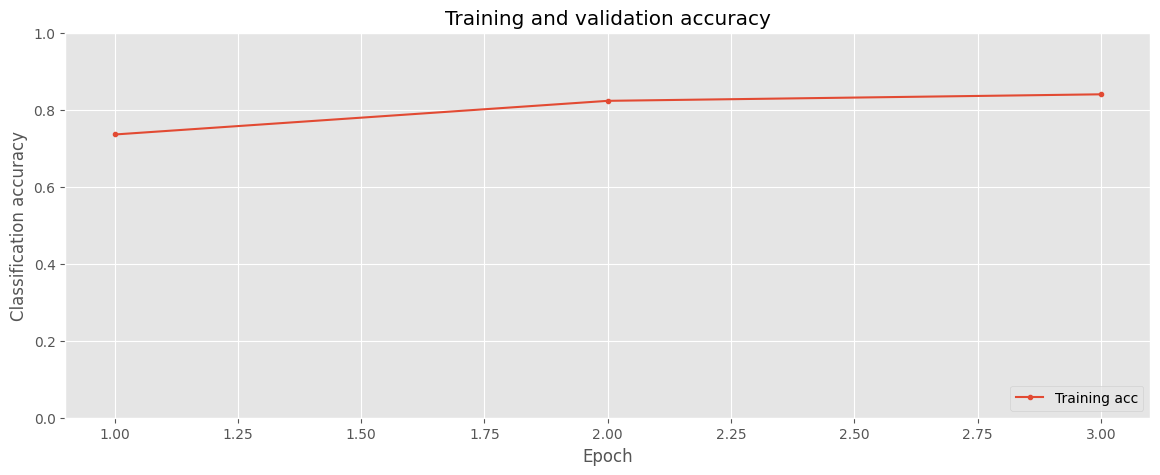

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
#val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
#val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
#plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);